In [ ]:
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import time

from dataset import *
from args import *
from train import *
from model import *

train_set, test_set, val_set = make_dataset(args)

average num of edges

In [ ]:
import math
import numpy as np

edge = [d.num_edges for i, d in enumerate(train_set)]
num_edge_array = np.array(edge)
print(train_set[0])
print("num_edges:", math.floor(num_edge_array.mean()))

In [ ]:
device = get_device()

train_set, test_set, val_set = make_dataset(args)

(
    train_data_loader,
    test_data_loader,
    val_data_loader,
) = make_data_loader(train_set, test_set, val_set)

in_channels = train_set[0].x.shape[-1]
out_channels = 50

model = GCNNetwork(in_channels, out_channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=50, min_lr=1e-8)

In [5]:
# extract
train_data_loader = [d for i, d in enumerate(train_data_loader)]
test_data_loader = [d for i, d in enumerate(test_data_loader)]
val_data_loader = [d for i, d in enumerate(val_data_loader)]

In [10]:
print(train_data_loader[0])
print(type(device))

DataBatch(edge_index=[2, 1970], edge_attr=[1970, 1], x=[162, 1], y=[10], batch=[162], ptr=[11])
<class 'torch.device'>


In [4]:
model.train()
total_loss = 0.0
for i, data in enumerate(train_data_loader):
        # data = train_data_loader[0]
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # [batch_size, formation_energy_per_atom]
        # # use Mean Absolute Error to calculate loss
        # loss = (out.squeeze() - data.y).abs().mean()
        # print("单图损失: ", loss)
        # loss.backward()
        # optimizer.step()
        # total_loss += loss.item() * data.num_graphs

No module named 'phonopy'
No module named 'phonopy'
No module named 'phonopy'
No module named 'phonopy'
No module named 'phonopy'
No module named 'phonopy'
No module named 'phonopy'
No module named 'phonopy'


: 

In [9]:
def train_step(model, train_data_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, data in enumerate(train_data_loader):
        # data = train_data_loader[0]
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # [batch_size, formation_energy_per_atom]
        # use Mean Absolute Error to calculate loss
        loss = (out.squeeze() - data.y).abs().mean()
        print("单图损失: ", loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    loss = total_loss / len(train_data_loader)
    return model, loss


@torch.no_grad()
def test_evaluations(model, data_loader, device):
    model.eval()
    total_loss = 0.0

    res_out = torch.zeros(0).to(device)
    res_y = torch.zeros(0).to(device)

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = data.to(device)
            out = model(data)
            total_loss += (out.squeeze() - data.y).abs().sum().item()

            res_out = torch.cat((res_out, out), 0)
            res_y = torch.cat((res_y, data.y), 0)

    loss = total_loss / len(data_loader)
    return loss, res_out, res_y

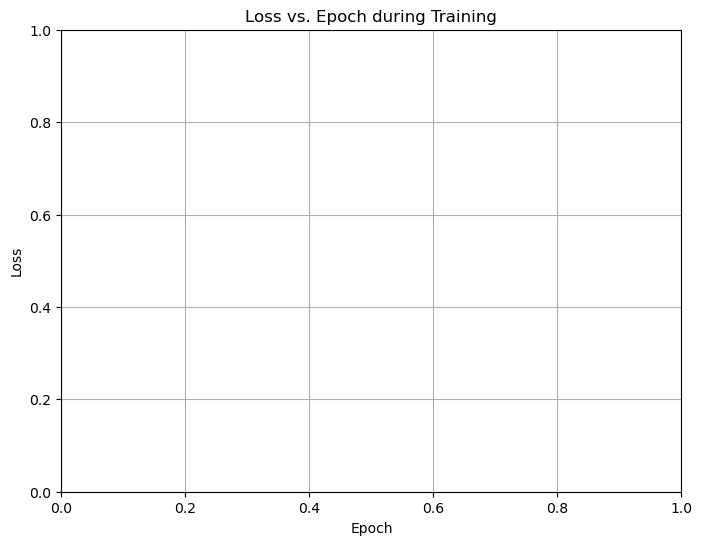

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)


# Plot the training progress
def plot_training_progress(epoch, train_losses, val_losses, test_losses, title):
    lw = 0.7  # linewidth
    ms = 0.7  # markersize

    # threshold = 1
    # for i in range(len(train_losses)):
    #     if train_losses[i] > threshold:
    #         train_losses[i] = threshold
    #     if val_losses[i] > threshold:
    #         val_losses[i] = threshold
    #     if test_losses[i] > threshold:
    #         test_losses[i] = threshold

    plt.plot(
        range(1, epoch + 1, 10),
        train_losses,
        marker="o",
        linestyle="-",
        color="b",
        lw=lw,
        ms=ms,
    )
    plt.plot(
        range(1, epoch + 1, 10),
        val_losses,
        marker="s",
        linestyle="-",
        color="r",
        lw=lw,
        ms=ms,
    )
    plt.plot(
        range(1, epoch + 1, 10),
        test_losses,
        marker="*",
        linestyle="-",
        color="g",
        lw=lw,
        ms=ms,
    )

    legend_entries = [
        Line2D([0], [0], color="blue", label="train_loss (Blue)"),
        Line2D([0], [0], color="red", label="validate_loss (Red)"),
        Line2D([0], [0], color="green", label="test_loss (Green)"),
    ]
    plt.title(title)

    plt.legend(handles=legend_entries, loc="upper right")
    plt.pause(0.001)

In [11]:
epochs = args["epochs"]

train_losses = []
test_losses = []
val_losses = []

for epoch in range(1, 2):
    model, train_loss = train_step(model, train_data_loader, optimizer, device)
    test_loss, test_out, test_y = test_evaluations(model, test_data_loader, device)
    val_loss, val_out, val_y = test_evaluations(model, val_data_loader, device)

    # Use val_loss to scheduler
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]["lr"]
    progress_msg = (
        "Epoch "
        + str(epoch)
        + ", training loss(MAE)="
        + str(round(train_loss, 4))
        + ", Validating loss(MAE)="
        + str(round(val_loss, 4))
        + ", testing loss(MAE)="
        + str(round(test_loss, 4))
        + ", lr="
        + str(round(current_lr, 8))
    )
    print(progress_msg)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    val_losses.append(val_loss)

    print("run")

: 

In [79]:
# plot_training_progress(
#     100, train_losses, val_losses, test_losses, "title"
# )
print(test_losses)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

legend_entries = [
    Line2D([0], [0], color="blue", label="train_loss (Blue)"),
    Line2D([0], [0], color="red", label="validate_loss (Red)"),
    Line2D([0], [0], color="green", label="test_loss (Green)"),
]
plt.legend(handles=legend_entries, loc="upper right")